<font size=7>Latencies Plot Visualizer

In [1]:
import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, plot_latency_dist_hist, plot_latency_angle_hist, \
                                 plot_cross_sttc_pairs, latencies, plot_vector_layout3
from human_hip.animate import animate_latencies
import human_hip.spike_data as spike_data

import pickle
import matplotlib.pyplot as plt
from ipywidgets import interact_manual
import numpy as np

# hc112823

In [2]:
sd = spike_data.read_autocurated_data( "/workspaces/human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/derived/kilosort2/Hc112823_avv9hckcr1_21841_120323_3_acqm.zip" )


# Try 1

In [3]:
cross_sttc_min_cutoff=2
cross_sttc_max_cutoff=30
sttc_cutoff = 0.04
latency_cutoff=2.5
sttc_delta=20 

# <font color="brown"> Old

In [10]:
import numpy as np
from human_hip.spike_data import latencies, cross_sttc

def curate_latencies(sd, cross_sttc_min_cutoff=2, cross_sttc_max_cutoff=30, sttc_cutoff = 0.04, latency_cutoff=2.5, sttc_delta=20 ):

    # Get all latencies whose STTC is above some minimum STTC cuttoff
    print(sd.N**2 , "Starting Pairs")
    sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
    pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
    for i in range(sd.N):
        for j in range(i+1,sd.N):
            if sttc_neo[i,j] > sttc_cutoff:
                pairs.append([i,j])
    print( len(pairs), "pairs above sttc cutoff")

    # Get all latencies whose median latency is above some minimum Latency Cuttoff
    pairs_late = [] #lags_late = []
    for pair in pairs:
        pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=cross_sttc_max_cutoff)  #latency= np.median(pair_latencies)
        if abs(np.mean(pair_latencies))> latency_cutoff and len(pair_latencies)>25:
        #if stats.ttest_1samp(pair_latencies,0)[1]<.1 and len(pair_latencies)>25:
            #pairs_late.append( pair )  #lags_late.append( latency )
            if np.mean(pair_latencies) < 0:
                pair_latencies = latencies( pair[1], pair[0], sd, ms_cutoff_high=cross_sttc_max_cutoff) 
                if np.mean(pair_latencies)> latency_cutoff and len(pair_latencies)>25:
                    #print("original pair: ", pair)
                    #print("added pair: ", [ pair[1], pair[0] ])
                    pairs_late.append( [ pair[1], pair[0] ] )   #lags_late.append( latency )
            else:
                pairs_late.append( pair ) 
    pairs_late
    print( len(pairs_late), "pairs above latencency cutoff")

    # print("Checking all latencies are positive")
    # mean_latencies = []
    # for pair in pairs_late:
    #     mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=cross_sttc_max_cutoff)  )
    #     mean_latencies.append(mean_latency)
    # print("All positvie?: ",np.all( np.array(mean_latencies)>0 ) )

    ##Do cross sttc for all pairs
    print("Starting cross_sttc calculation... might take a minute")
    cross_lag  = [] 
    for pair in pairs_late: 
        sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
        max_args = np.argwhere(sttcs == np.amax(sttcs)) - 1000 
        cross_lag.append( max_args[np.argmin(np.abs(max_args))][0] )   # if multiple maxima, take the one closest to zero
    cross_lag = np.array(cross_lag)
    to_keep = np.where(( cross_lag< cross_sttc_max_cutoff) & (cross_lag> cross_sttc_min_cutoff) & (cross_lag!=0) )[0]
    print( len(to_keep), "pairs between cross_sttc cutoffs")

    pairs_final = []
    for i in to_keep:
        pairs_final.append(pairs_late[i])
    
    mean_latencies = []
    for pair in pairs_final:
        mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=cross_sttc_max_cutoff)  )
        mean_latencies.append(mean_latency)
    print("all final pairs positive?:", np.all( np.array(mean_latencies)>0 ))
    #good_pairs =   np.array(pairs_final)

    return  pairs_final



In [18]:
# good_pairs = curate_latencies(sd)
# good_pairs2 = np.array(good_pairs)

#dump good pairs into 'hc112823_good_pairs.pkl'
# with open( 'hc112823_acid_good_pairs.pkl', 'wb') as my_file:
#     pickle.dump(good_pairs, my_file)

with open( 'hc112823_acid_good_pairs.pkl' , 'rb') as my_file:
    good_pairs = pickle.load(my_file)
    good_pairs2= np.array(good_pairs)
# print(len(good_pairs))

In [19]:
plot_latency_angle_hist

<function human_hip.spike_data.plot_latencies.plot_latency_angle_hist(sd, pairs, by_firing_rate=False, late_cutoff_low=1, late_cutoff_high=15)>

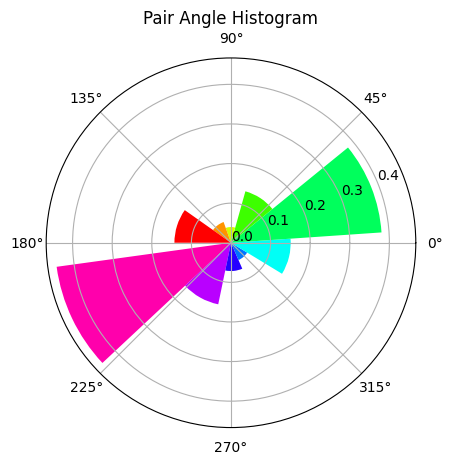

In [12]:
plot_latency_angle_hist(sd, good_pairs2, by_firing_rate=False, late_cutoff_high=30)

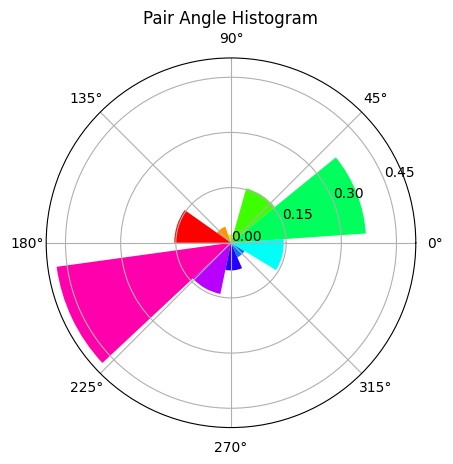

In [13]:
plot_latency_angle_hist(sd, good_pairs2, by_firing_rate=True, late_cutoff_high=30)

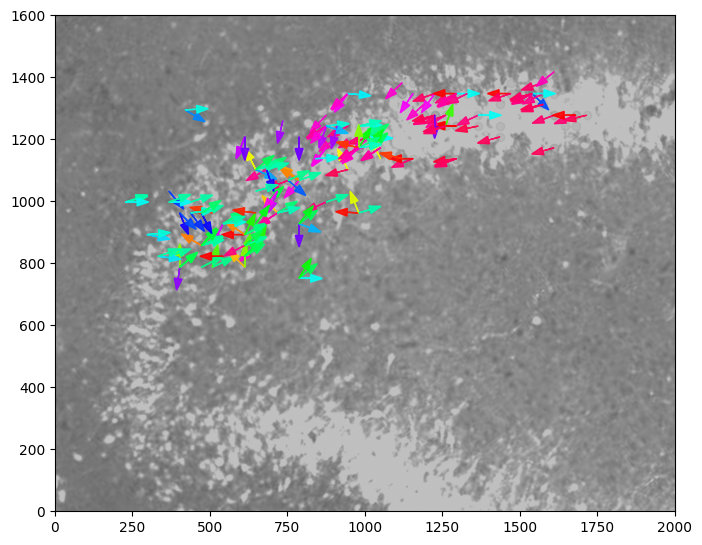

In [14]:
plot_vector_layout( sd, good_pairs2,  image_path="/workspaces/human_hippocampus/data/histology/hc112823_bw_old.png",
                     xlim=(0,2000), ylim=(0,1600) )

In [19]:
from ipywidgets import interact_manual, interact
from scipy import stats

def pairs_hisogram(good_pairs, sd, ms_cutoff_high=30):
    @interact
    def plot_pair(pair_i = (0, len(good_pairs)-1) ):
        latencies_pair = latencies( good_pairs[pair_i][0], good_pairs[pair_i][1], sd, ms_cutoff_high=ms_cutoff_high )
        plt.xlim(-ms_cutoff_high, ms_cutoff_high)
        plt.hist(latencies_pair, bins=12)
        print("Pair: ", good_pairs[pair_i][0],good_pairs[pair_i][1] )
        print("Latency Mean:\t", np.mean(latencies_pair ) )

        t_stat, p_value = stats.ttest_1samp( latencies_pair, 0)
        one_sided_p_value = p_value / 2 if t_stat > 0 else 1 - p_value / 2
        print("T-Test 1-Side:\t", one_sided_p_value )  #print("T-Test: ", stats.ttest_1samp(latencies_pair, 0)[1] )
        
pairs_hisogram( good_pairs, sd, ms_cutoff_high=30)

interactive(children=(IntSlider(value=102, description='pair_i', max=204), Output()), _dom_classes=('widget-in…

# <font color="brown">Figure out negative latency pairs

In [14]:
pairs = good_pairs

In [15]:
cross_sttc_min_cutoff=2
cross_sttc_max_cutoff=30
sttc_cutoff = 0.04
latency_cutoff=2.5
sttc_delta=20 

In [16]:
len(pairs)

205

In [26]:
print(sd.N**2 , "Starting Pairs")
sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
pairs2 = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
for pair in pairs:
    if sttc_neo[pair[0],pair[1] ] > sttc_cutoff:
        pairs2.append(pair)
print( len(pairs2), "pairs above sttc cutoff")

44944 Starting Pairs
205 pairs above sttc cutoff


In [30]:
pairs_late = []
for pair in pairs2:
    pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=cross_sttc_max_cutoff)  #latency= np.median(pair_latencies)
    if abs(np.mean(pair_latencies))> latency_cutoff and len(pair_latencies)>25:
        if np.mean(pair_latencies) > 0:
            pairs_late.append( pair ) 
        else:
            pair_latencies = latencies( pair[1], pair[0], sd, ms_cutoff_high=cross_sttc_max_cutoff) 
            if np.mean(pair_latencies)> latency_cutoff and len(pair_latencies)>25:
                pairs_late.append( [ pair[1], pair[0] ] )   #lags_late.append( latency )

In [32]:

len(pairs_late)

191

In [28]:
mean_latency = []
for pair in pairs2:
    pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=cross_sttc_max_cutoff) 
    mean_latency.append( np.mean(pair_latencies) )


In [29]:
mean_latency

[2.7060240963853466,
 4.149999999999272,
 4.74682539682423,
 2.785624999999139,
 4.030769230768708,
 2.7134920634883053,
 3.4728155339786757,
 3.705769230768013,
 3.5293650793618028,
 5.053174603178478,
 3.4824999999978803,
 2.5245901639325177,
 0.7283333333330575,
 3.5735294117570153,
 -2.2529411764704386,
 3.0929752066127127,
 2.6727941176504157,
 5.5637931034494175,
 7.890909090907853,
 -3.484042553192544,
 3.2174418604656183,
 4.7504901960771555,
 3.664516129031881,
 7.698076923076314,
 2.6326923076966953,
 2.5591549295773213,
 -1.9062499999988196,
 -2.7609090909087337,
 3.40180995475007,
 4.827777777769639,
 -3.234482758611005,
 5.1078947368379986,
 3.7523255813958305,
 2.8426666666647877,
 2.598684210521984,
 3.6428571428592664,
 2.6306122448914553,
 3.359821428569682,
 3.668465909090588,
 3.108955223880532,
 4.34285714286153,
 5.43428571428549,
 2.709090909089961,
 5.4464285714302445,
 3.025438596490435,
 5.195689655172318,
 3.729032258062445,
 3.6709459459466047,
 5.50400000000

In [ ]:
pairs_late = [] #lags_late = []
for pair in pairs2:
    pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=cross_sttc_max_cutoff)  #latency= np.median(pair_latencies)
    if abs(np.mean(pair_latencies))> latency_cutoff and len(pair_latencies)>25:
        if np.mean(pair_latencies) < 0:
            pair_latencies = latencies( pair[1], pair[0], sd, ms_cutoff_high=cross_sttc_max_cutoff) 
            if np.mean(pair_latencies)> latency_cutoff and len(pair_latencies)>25:
                pairs_late.append( [ pair[1], pair[0] ] )   #lags_late.append( latency )
        else:
            pairs_late.append( pair ) 

In [ ]:

    # Get all latencies whose median latency is above some minimum Latency Cuttoff
    pairs_late = [] #lags_late = []
    for pair in pairs:
        pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=cross_sttc_max_cutoff)  #latency= np.median(pair_latencies)
        if abs(np.mean(pair_latencies))> latency_cutoff and len(pair_latencies)>25:
        #if stats.ttest_1samp(pair_latencies,0)[1]<.1 and len(pair_latencies)>25:
            #pairs_late.append( pair )  #lags_late.append( latency )
            if np.mean(pair_latencies) < 0:
                pair_latencies = latencies( pair[1], pair[0], sd, ms_cutoff_high=cross_sttc_max_cutoff) 
                if np.mean(pair_latencies)> latency_cutoff and len(pair_latencies)>25:
                    pairs_late.append( [ pair[1], pair[0] ] )   #lags_late.append( latency )
            else:
                pairs_late.append( pair ) 

    pairs= pairs_late
    print( len(pairs_late), "pairs above latencency cutoff")

    ##Do cross sttc for all pairs
    print("Starting cross_sttc calculation... might take a minute")
    cross_lag  = [] 
    for pair in pairs: 
        sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
        max_args = np.argwhere(sttcs == np.amax(sttcs)) - 1000 
        cross_lag.append( max_args[np.argmin(np.abs(max_args))][0] )   # if multiple maxima, take the one closest to zero
    cross_lag = np.array(cross_lag)
    to_keep = np.where(( cross_lag< cross_sttc_max_cutoff) & (cross_lag> cross_sttc_min_cutoff) & (cross_lag!=0) )[0]
    print( len(to_keep), "pairs between cross_sttc cutoffs")
    return np.array(pairs)[ to_keep ] 
